In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# from models.convolutional_vqvae import ConvolutionalVQVAE, preprocess_grid, postprocess_grid
from models.convolutional_vae import ConvolutionalVAE, preprocess_grid, postprocess_grid
# from models.convolutional_vae_v2 import ConvolutionalVAEV2, preprocess_grid, postprocess_grid
# from models.fully_connected_vae import FullyConnectedVAE
# from models.vq_pipeline import preprocess_grid, postprocess_grid, get_compression_functions
from models.pipeline import Pipeline
from utils.view import draw_grid


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ConvolutionalVQVAE(
#     in_channels=10, 
#     starting_filters=64, 
#     num_embeddings=256,
#     embedding_dim=64,
#     commitment_cost=0.1
# ).to(device)

model = ConvolutionalVAE(
        in_channels=10, 
        num_filters=128, 
        latent_dim=128,
        feature_dim=[2, 2]
    ).to(device)

# model = ConvolutionalVAEV2(
#     in_channels=10, 
#     starting_filters=64, 
#     latent_dim=128,
#     feature_dim=[8, 8]
# ).to(device)

# model = FullyConnectedVAE(
#     input_dim=64*6*6,
#     hidden_dim=1024,
#     latent_dim=64
# ).to(device)

# checkpoint = torch.load('../../checkpoints/conv_vqvae_batchnorm_6x6x64.pt', map_location=device)
# checkpoint = torch.load('../../checkpoints/conv_vaev2_bacthnorm_lat128_beta05.pt', map_location=device)
# checkpoint = torch.load('../../checkpoints/vqvae_vae_64.pt', map_location=device)
checkpoint = torch.load('../../checkpoints/conv_vae_batchnorm_lat128.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# compress_fn, decompress_fn = get_compression_functions('../../checkpoints/conv_vqvae_batchnorm_6x6x64.pt')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_grid,
    postprocess_fn=postprocess_grid,
    # compress_fn=compress_fn,
    # decompress_fn=decompress_fn,
)

In [2]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

In [3]:
def compute_accuracy(original, decoded):
        correct = (original == decoded)
        accuracy = correct.mean().item()
        is_perfect = accuracy == 1.0
        return accuracy, is_perfect

def reconstruct_grids(pipeline: Pipeline, task, mode, model_type="vq"):
    def reconstruct_grid(grid, expected_grid, model_type):
        grid = pipeline.preprocess_and_compress(grid)
        
        grid_decoded = None

        if model_type == 'vq':
            z_e = pipeline.encode(grid.unsqueeze(0).to(device))
            z_q, _, _ = pipeline.model.quantize(z_e.to(device))
            grid_decoded = pipeline.decode(z_q)
        else:
            z, _ = pipeline.encode(grid.unsqueeze(0).to(device))
            grid_decoded = pipeline.decode(z.unsqueeze(0).to(device))

        grid_decoded = pipeline.decompress_and_postprocess(grid_decoded.squeeze(0), expected_grid)
        return grid_decoded
    
    pipeline.model_eval()
    with torch.no_grad():
        pairs = task[mode]

        inputs = []
        inputs_recon = []
        
        outputs = []
        outputs_recon = []
        
        for input, output in pairs:
            inputs.append(input)
            input_decoded = reconstruct_grid(input, input, model_type)
            inputs_recon.append(input_decoded)
            
            outputs.append(output)
            output_decoded = reconstruct_grid(output, output, model_type)
            outputs_recon.append(output_decoded)
        
        return inputs, inputs_recon, outputs, outputs_recon


In [4]:
train_recon_accuracy_per_task = {}
train_perf_per_task = {}

original_grids = []
decoded = []

# counter = 0
for puzzle_id, task in data.items():
    # if counter >= 10:
    #     break
    # counter += 1
    i, i_recon, o, o_recon = reconstruct_grids(pipeline, task, "test", "vae")
    accuracies = []
    perfects = []
    
    original_grids.extend(i)
    original_grids.extend(o)
    decoded.extend(i_recon)
    decoded.extend(o_recon)

    for idx, (original, reconstructed) in enumerate(zip(i, i_recon)):
        acc, perf = compute_accuracy(original, reconstructed)
        accuracies.append(acc)
        perfects.append(perf)

    for idx, (original, reconstructed) in enumerate(zip(o, o_recon)):
        acc, perf = compute_accuracy(original, reconstructed)
        accuracies.append(acc)
        perfects.append(perf)
    
    train_recon_accuracy_per_task[puzzle_id] = np.mean(accuracies)
    train_perf_per_task[puzzle_id] = np.mean(perfects)
    show_recon = False
    if show_recon:
        batch_size = len(i)
        fig, axs = plt.subplots(4, batch_size, figsize=(batch_size * 2, 8))

        titles = ["Input", "Input Recon", "Output", "Output Recon"]
        all_grids = [i, i_recon, o, o_recon]

        for row, (title, grids) in enumerate(zip(titles, all_grids)):
            for col in range(batch_size):
                img = grids[col]
            
                ax = axs[row, col] if batch_size > 1 else axs[row]
                draw_grid(ax, img, title if col == 0 else "")

        plt.tight_layout()
        plt.show()

        
    # print(puzzle_id, np.mean(accuracies), np.mean(perfects))

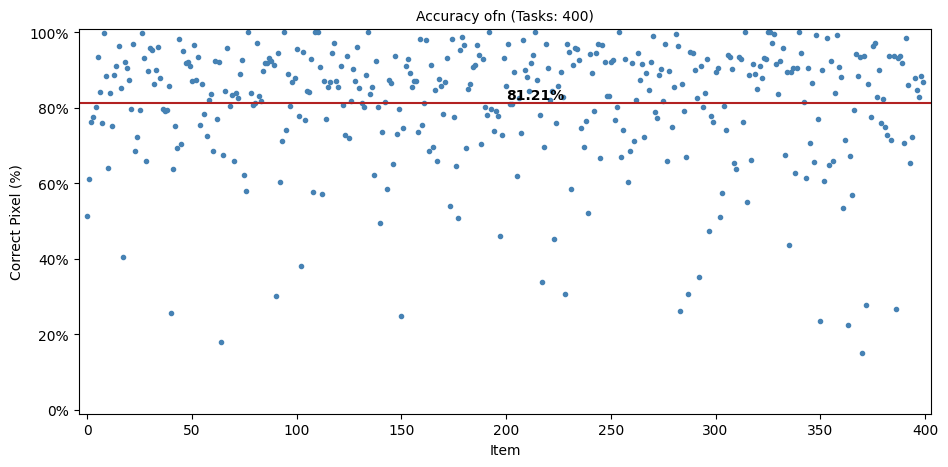

Number of 100% Correct: 12
Number of 90%+ Correct: 143
Number of 80%+ Correct: 259
Number of 70%+ Correct: 326


In [5]:
accuracies = list(train_recon_accuracy_per_task.values())
mean = np.mean(accuracies)

ig, ax = plt.subplots(figsize=(11,5))
plt.plot(accuracies, color='steelblue', marker='.', linewidth=0)
plt.axhline(mean, xmax = len(accuracies), color='firebrick')
plt.title(f'Accuracy ofn (Tasks: {len(accuracies)})', size='medium')
plt.xlabel('Item')
plt.ylabel('Correct Pixel (%)')
plt.text(len(accuracies)/2, mean+0.01, f'{(mean*100).round(2)}%', size='medium', weight='bold')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
plt.ylim(-0.01, 1.01)
plt.margins(x=0.01)
plt.show()
print(f'Number of 100% Correct: {accuracies.count(1)}')
print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in accuracies)}')
print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in accuracies)}')
print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in accuracies)}')

dict_keys([np.int64(8), np.int64(6), np.int64(3), np.int64(1), np.int64(0), np.int64(4), np.int64(2), np.int64(7), np.int64(9), np.int64(5)])


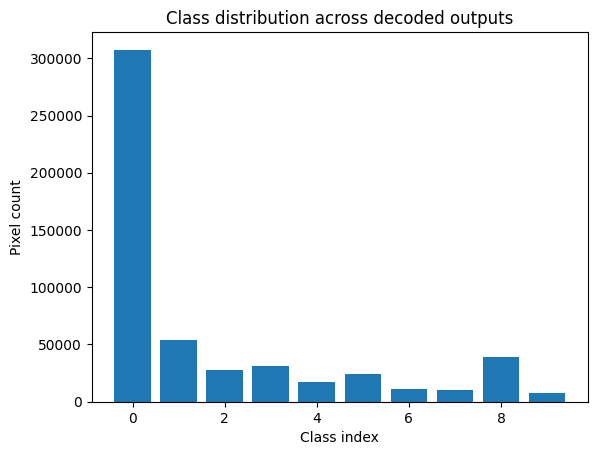

In [7]:
from collections import Counter

all_preds = []
for d in decoded:
    a = np.array(d).flatten()

    all_preds.extend(a)

counts = Counter(all_preds)
print(counts.keys())

plt.bar(counts.keys(), counts.values())
plt.xlabel("Class index")
plt.ylabel("Pixel count")
plt.title("Class distribution across decoded outputs")
plt.show()


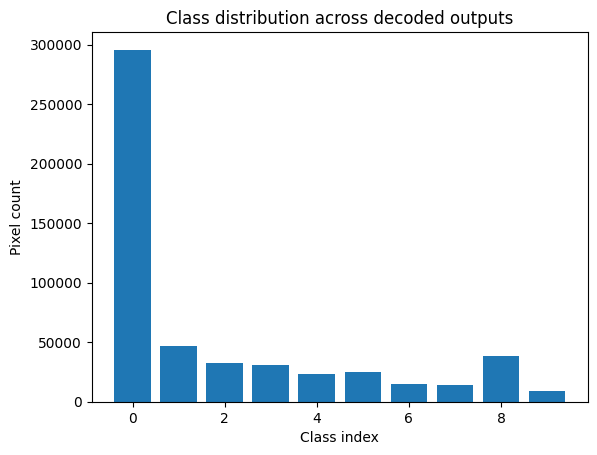

In [8]:
all_orig = []
for o in original_grids:
    a = np.array(o).flatten()

    all_orig.extend(a)

counts = Counter(all_orig)

plt.bar(counts.keys(), counts.values())
plt.xlabel("Class index")
plt.ylabel("Pixel count")
plt.title("Class distribution across decoded outputs")
plt.show()